<a href="https://colab.research.google.com/github/CeciliaGaiani/LSN/blob/main/LSN_Exercises_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

## <span style="color:orange"> **Note teoriche**
### **Reti Neurali Convoluzionali (CNNs)**
Molti problemi affrontati attraverso algoritmi di machine learning presentano strutture e simmetrie intrinseche. Tra queste figurano la
**località**, il fatto che le informazioni rilevanti si limitino a porzioni finite più o meno ampie di dati, e l'**invarianza traslazionale**, per cui le caratteristiche significative dei dati non dipendono dalla posizione assoluta, ma solo dal fatto che siano presenti.

Un esempio evidente di ciò si osserva negli algoritmi di supervised learning per la classificazione di immagini. In questi casi, l’algoritmo deve essere in grado di riconoscere determinate caratteristiche visive, come bordi, curve o texture, indipendentemente da dove si trovano all’interno dell’immagine, al fine di collocarla in una data classe di appartenenza. Queste caratteristiche sono spesso locali, e la loro presenza è ciò che conta, non la loro posizione specifica.

A tal fine, sono state disegnate le **Reti Neurali Convoluzionali (CNNs)**, che sono in grado di soddisfare località e invarianza traslazionale dei dati di input. Le CNN sono costruite su due tipi di layer di neuroni:
- **layer di convoluzione**: il layer legge l'input e applica una serie di **filtri**. I filtri scorrono sull'immagine calcolando la **convoluzione**, cioè una media pesata di pixel vicini, al fine di estrarre le caratteristiche locali dell'immagine, come bordi, texture e forme. In questo modo, l'immagine originale è trasformata in mappe caratteristiche, ciascuna delle quali evidenzia dettagli specifici dell'immagine;

- **layer di pooling**: riduce la dimensione spaziale dell'input, e così il numero di dati da elaborare, preservavando le informazioni più importanti relative alla struttura spaziale (posizione e vicinanza degli elementi), grazie alle informazioni estratte dai filtri.

In una CNN, ogni layer convoluzionale $l$ ha:

- **Altezza** ($H_l$) e **larghezza** ($W_l$), che rappresentano la dimensione spaziale bidimensionale del layer (in neuroni). Nel caso dell'input layer per un'immagine, $H_l \times W_l$ corrisponde al numero di pixel dell'immagine;
- **Profondità** ($D_l$), che indica il numero di canali del layer. Ad esempio, un’immagine RGB ha 3 canali.

Per ogni layer sono applicati dei **filtri locali**, che prendono in input una piccola porzione spaziale del layer precedente su ciascun canale. Nel caso 2D, consideriamo un filtro quadrato di dimensione $F \times F$: si può rappresentare come una matrice le cui componenti, definite **pesi**, hanno valori legati a ciò che il filtro sta cercando. Il filtro ha profondità pari al numeri di canali dell'input.

L’operazione di convoluzione consiste nel far scorrere il filtro su tutto lo spazio, realizzando un prodotto scalare tra i pesi e la regione di input corrispondente. Tale operazione è effettuata per ogni canale in maniera indipendente, al fine di ottenere per ognuno di essi una diversa mappa di attivazione, ciascuna delle quali cattura una diversa caratteristica dell'immagine analizzata. Il numero di neuroni di cui trasliamo il filtro per ogni step è detto **stride $S$**. Eventualmente, è possibile aggiungere un **padding $P$**, cioè degli zeri ai bordi dell'input, per controllare le dimensioni dell’output della convoluzione e preservare le informazioni ai bordi dell’input.

Dopo l'applicazine del filtro ad un layer di altezza $H_{in}$ e larghezza $W_{in}$, la dimensione dell'output risulta:

$$
\text{Output}_{altezza} = \left\lfloor \frac{H_{in} - F + 2P}{S} \right\rfloor + 1
$$

$$
\text{Output}_{larghezza} = \left\lfloor \frac{W_{in} - F + 2P}{S} \right\rfloor + 1
$$

I risultati associati all'applicazione del filtro per ogni canale vengono poi sommati al fine di ottenere un unico output. La profondità  del layer di output sarà pari al numero di filtri utilizzati. Eventualmente, è possibile aggiungere un **bias** $b$, che viene sommato al risultato del prodotto scalare, permettendo al neurone di attivarsi anche se la somma pesata degli input è nulla (è possibile spostare la soglia di attivazione del filtro, al fine di rappresentare anche pattern più complessi che altrimenti non sarebbero visibili).

Successivamente, vengono applicati i layer di pooling, che hanno lo scopo di ridurre la dimensione spaziale dell'output preservando le informazioni individuate nel processo di convoluzione. Il più comune layer di convoluzione è il **max-pooling**, in cui si legge un piccolo blocco locale e lo sostituisce con il valore massimo del blocco.

Successivamente vengono inseriti un **fully connected layer**, al fine di collegare ogni neurone a tutti i neuroni del filtro precedente, combinando le caratteristiche estratte e prendere la decisione globale, sfruttando tutte le informazioni a disposizone, e da
un **layer Softmax**, che trasforma l'output numerico del fully connected layer nella probabilità si appartenenza ad una data classe.

Le CNN si allenano con lo stesso algoritmo delle reti neurali standard, cioè la **backpropagation**. La differenza è che nelle CNN i parametri (pesi e bias) sono condivisi tra neuroni dello stesso filtro, quindi il numero totale di parametri è molto più basso, permettendo di allenare modelli molto più vasti e profondi. Inoltre, i filtri appresi da una CNN riconoscono caratteristiche visive fondamentali (es. bordi, curve), che sono comuni in tante immagini, per cui quanto appreso su un certo dataset può funzionare, a patto di modifiche minimali, anche su altri input simili.    

---

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
from keras.datasets import mnist

# Dimensioni dell'immagine di input (numero di pixels).
img_rows, img_cols = 28, 28

# Numero delle classi di output: sono le 10 cifre da 0 a 9.
num_classes = 10

# X_train: contiene le immagini usate per l’addestramento (60.000 immagini).
# Y_train: contiene le etichette corrispondenti alle immagini di training (cioè la cifra che rappresenta ogni immagine).
# X_test e Y_test fanno la stessa cosa ma per il set di test (10.000 immagini).
# Dopo il caricamento, il codice stampa le dimensioni degli array X_train e Y_train. Questo serve a verificare che i dati siano stati caricati correttamente.
# X_train.shape dovrebbe stampare (60000, 28, 28), ovvero 60.000 immagini da 28x28 pixel. Y_train.shape, invece, dovrebbe stampare (60000,), cioè un array con 60.000 valori numerici (da 0 a 9). Stessa cosa vale per i dati test.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [3]:
# Si consideri un array di etichette, ciascuna delle quali appartiene ad una delle possibili classi {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])

# to_categorical trasforma ciascuna etichetta numerica in un vettore binario in cui la posizione corrispondente alla classe viene impostata a 1.
# Tutte le altre posizioni vengono impostate a 0. Ad esempio: l’etichetta 0 diventa [1, 0, 0], l’etichetta 1 diventa [0, 1, 0], l’etichetta 2 diventa [0, 0, 1].

keras.utils.to_categorical(labels)

# L'array è trasformato come riportato sotto:

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

An example of a data point with label 4


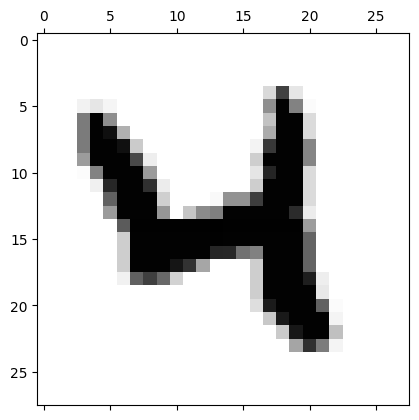

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# Trasformo ciascuna immagine 28x28 in un vettore di 784 componenti. Dunque, prima: X_train.shape = (60000, 28, 28); dopo: X_train.shape = (60000, 784).
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# Tutti i pixel (inizialmente numeri interi tra 0 e 255) vengano trattati come numeri in virgola mobile.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Ogni valore di pixel è diviso per 255, cioè il valore massimo possibile per un pixel in scala di grigi.
# In questo modo i valori dei pixel sono compresi tra 0 e 1.
X_train /= 255
X_test /= 255

# Esempio: viene stampata l’etichetta (cioè la cifra) dell’immagine in posizione 20, e poi viene ricostruita e visualizzata l’immagine corrispondente, usando matshow di Matplotlib.
# X_train[20,:] è il vettore lungo 784 che rappresenta l’immagine in posizione 20.
# .reshape(28,28) lo riporta alla forma originale per poterlo disegnare.

print('An example of a data point with label', Y_train[20])
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# Uso di to_categorical per trasformare le etichette delle cifre da 0 a 9 (necessario per usare la funzione crossentropy come loss).
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`.

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Creazione della rete neurale. Modello sequenziale in cui si utilizzano:
# - primo layer di neuroni, con 400 neuroni, ciascuno completamente connesso a tutti i 784 input. La funzione di attivazione è ReLU;
# - secondo layer, anche questo completamente connesso, con 100 neuroni e attivazione ReLU;
# - layer di dropout, che disattiva casualmente il 50% dei neuroni  durante l’addestramento;
#   Serve per evitare l'overfitting. Durante il test o la predizione, il dropout è disattivato e il modello usa tutti i neuroni;
# - Layer denso in cui il numero di neuroni corrisponde al numero di classi (in questo caso 10, cioè le cifre da 0 a 9).
#   L’attivazione softmax converte l’output in probabilità, cioè un vettore con 10 valori compresi tra 0 e 1 che sommano a 1.
#   Questo permette al modello di definire con che probabilità l’immagine appartiene a ciascuna classe.

def create_DNN():
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

# Creo e compilo il modello. Come funzione di loss si usa la categorical_crossentropy.
# Serve a misurare quanto l’output del modello si discosta dalle etichette reali. Più è bassa, meglio il modello sta imparando.
# Si può scegliere l'ottimizzatore da utilizzare.
# Come metrica di valutazione si usa l'accuratezza, cioè la percentuale di esempi classificati correttamente durante l’addestramento e la valutazione.

def compile_model():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['acc'])
    return model

#### Step 4: Train the model

We train our DNN in minibatches.

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`.

In [7]:
# Training del modello
batch_size = 32
epochs = 50
model_DNN = compile_model()

history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, Y_test))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.8561 - loss: 0.4779 - val_acc: 0.9650 - val_loss: 0.1099
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9606 - loss: 0.1384 - val_acc: 0.9683 - val_loss: 0.0999
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9719 - loss: 0.0982 - val_acc: 0.9765 - val_loss: 0.0763
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9790 - loss: 0.0724 - val_acc: 0.9792 - val_loss: 0.0746
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - acc: 0.9823 - loss: 0.0565 - val_acc: 0.9777 - val_loss: 0.0806
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - acc: 0.9853 - loss: 0.0473 - val_acc: 0.9789 - val_loss: 0.0838
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9856 - loss: 0.0452 - val_acc: 0.9798 - val_loss: 0.0815
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - acc: 0.9889 - loss: 0.0351 - val_acc: 0.9798 - val_loss: 0.0906
Epoch 9/50
1875/1875 ━━━━━━━━━

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9791 - loss: 0.2343
Test loss: 0.20459197461605072
Test accuracy: 0.9824000000953674


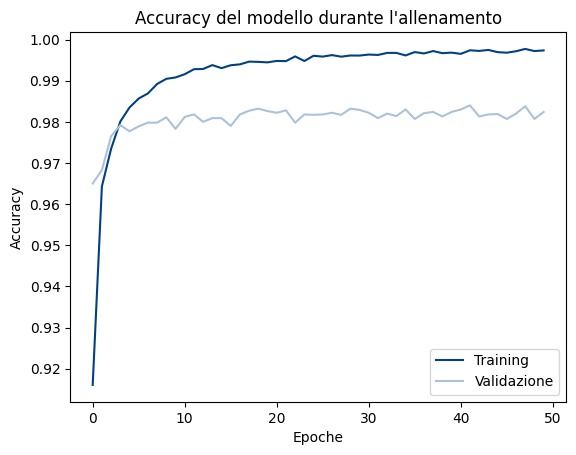

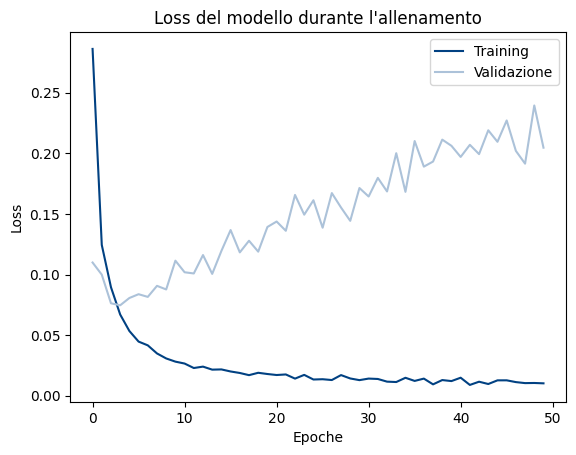

In [8]:
# Test del modello sui dati di validazione. Restituisce due valori:
# - Loss (perdita): misura quanto le previsioni del modello si discostano dalla realtà.
# - Accuracy (accuratezza): percentuale di esempi classificati correttamente.
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# Stampo loss e accuracy per il set di validazione
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot dell'accuracy durante l'allenamento
plt.plot(history.history['acc'], color='xkcd:darkish blue')
plt.plot(history.history['val_acc'], color='xkcd:cloudy blue')
plt.ylabel('Accuracy')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validazione'], loc='best')
plt.title('Accuracy del modello durante l\'allenamento')
plt.show()

# Plot della loss durante l'allenamento
plt.plot(history.history['loss'], color='xkcd:darkish blue')
plt.plot(history.history['val_loss'], color='xkcd:cloudy blue')
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validazione'], loc='best')
plt.title('Loss del modello durante l\'allenamento')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


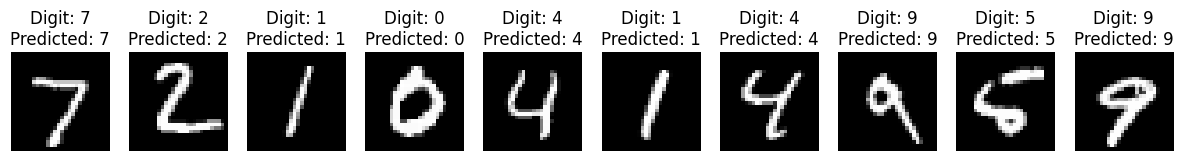

In [9]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15))
for i in range(10): # Mostro le prime 10 immagini e la loro etichetta
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

### *Esercizio 12.1 - Soluzione proposta*
Per lo svolgimento di questo esercizio, è stato utilizzato lo script fornito per studiare come variano loss ed accuracy del modello a seconda del tipo di ottimizzatore.

La rete neurale è stata costruita come segue:
- un primo layer di neuroni, con 400 neuroni, ciascuno completamente connesso a tutti i 784 input. La funzione di attivazione è ReLU;
- un primo hidden layer, completamente connesso, con 100 neuroni e attivazione ReLU;
- layer di dropout, che disattiva casualmente il 50% dei neuroni  durante l’addestramento, al fine di evitare l'overfitting. Durante il test o la predizione, il dropout è disattivato e il modello usa tutti i neuroni;
- layer denso in cui il numero di neuroni corrisponde al numero di classi (in questo caso 10, cioè le cifre da 0 a 9); l’attivazione avviene tramite softmax, che converte l’output in probabilità, cioè un vettore con 10 valori compresi tra 0 e 1 che sommano a 1. Questo permette al modello di definire in output con che probabilità l’immagine appartiene a ciascuna classe.

Come funzione di perdita si utilizza la `categorical_crossentropy`, che serve a misurare quanto l’output del modello si discosta dalle etichette reali. Più è bassa, meglio il modello sta imparando.

Sono state analizzate le performance della rete utilizzando tre ottimizzatori differenti. Per ciascuno, si riportano i risultati relativi a loss ed accuracy sul set di validazione, ad opera del modello allenato in $N_{epochs}=50$ epoche:

1. *Stochastic Gradient Descent (SGD)*:
  - Test loss: 0.06095379590988159
  - Test accuracy: 0.9817000031471252

2. *Adamax* $\rightarrow$ ottimizzatore basato su Adam, che adatta automaticamente il learning rate in base ai gradienti calcolati per ciascun peso, utilizzando la norma $L^{(\infty)}$:
  - Test loss: 0.07883846014738083
  - Test accuracy: 0.9833999872207642

3. *Root Mean Square Propagation (RMSprop)* $\rightarrow$ ottimizzatore che adatta il learning rate in base alle stime del momento del secondo ordine dei gradienti; rispetto ad Adam, RMSprop tende a dare più peso ai gradienti recenti rispetto ai gradienti passati:
  - Test loss: 0.28334733843803406
  - Test accuracy: 0.9828000068664551

Indipendentemente dal tipo di ottimizzatore, il modello è stato in grado di riconoscere correttamente le cifre proposte.

---


#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [10]:
# Le reti neurali convoluzionali (CNN) non lavorano con dati "linearizzati" (ovvero trasformati in vettori), ma con immagini come matrici 2D o 3D (includendo il canale).
# Quindi, siccome prima le immagini sono state convertite in vettori di 784 componenti, bisogna ricostruirle nella loro forma originale, aggiungendo anche il canale del colore (nel caso di MNIST, è 1 perché sono in scala di grigi).
from keras.layers import Flatten, Conv2D, MaxPooling2D

if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2


Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

### *Esercizio 12.2 - Soluzione proposta*
Per lo svolgimento di questo esercizio, la rete neurale sviluppata nell'Esercizio 12.1 è stata rielaborata al fine di costruire una DNN con layers convoluzionali. La rete è strutturata come segue:
1. layer convoluzionale con 32 filtri di dimensione 5x5. La funzione di attivazione è la ReLU. `input_shape` indica la forma delle immagini in input (es. 28x28x1).
Questo layer scansiona l’immagine con 32 filtri diversi per estrarne le caratteristiche;
2. layer di MaxPooling con finestre 2x2 e passo 2.
Serve per ridurre la dimensione spaziale (larghezza e altezza) delle immagini, mantenendo le caratteristiche più importanti;
3. layer convoluzionale con 64 filtri di dimensione 3x3. La funzione di attivazione è la ReLU;
4. layer di MaxPooling con finestre 2x2 e passo 2, che permette di ridurre ancora la dimensione delle immagini.

Dopo che i dati relativi alle immagini sono stati convertiti da matrice 2D a array 1D (`flatten`), si inseriscono i layer densi:
1. layer denso con 50 neuroni e attivazione ReLU;
2. layer di dropout (al 50%)
2. layer denso con 20 neuroni e attivazione ReLU;
3. layer denso con `num_classes` neuroni (10 per MNIST) e attivazione `softmax`.

La rete è stata allenata per $N_{epochs}=25$ epoche, utilizzando come ottimizzatore l'algoritmo di Stochastic Gradient Descent, e come funzione di perdita la `categorical_crossentropy`.

In [11]:
def create_CNN():
    # Modello sequenziale
    model = Sequential()

    # Layer convoluzionale con 32 filtri 5x5 e attivazione ReLu
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape)) # input_shape indica la forma delle immagini in input (es. 28x28x1).

    # Layer di MaxPooling2D con finestre 2x2 e passo 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Layer convoluzionale con 64 filtri 3x3 e attivazione ReLu
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))

    # Layer di MaxPooling2D con finestre 2x2 e passo 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Converte i dati da matrice 2D a vettore 1D per poterli collegare ai layer densi
    model.add(Flatten())

    # Layer densi:
    # - 1° layer denso con 50 neuroni e attivazione ReLU
    # - 2° layer di dropout
    # - 3° layer denso con 20 neuroni e attivazione ReLu
    # - 4° layer denso con num_classes neuroni (10 in questo caso) e attivazione softmax, che trasforma l’output in una distribuzione di probabilità sulle 10 classi.
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD', # Ottimizzatore SGD
                  metrics=['acc']) # Monitorare accuracy per valutare il set di dati test
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [12]:
# Parametri del training
batch_size = 32
epochs = 25

# Crezione e training del modello
model_CNN=create_CNN()
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, Y_test))

# Test del modello con il set di validazione e valutazione di loss e accuracy
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - acc: 0.4306 - loss: 1.6017 - val_acc: 0.9341 - val_loss: 0.2261
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - acc: 0.8725 - loss: 0.4060 - val_acc: 0.9630 - val_loss: 0.1230
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - acc: 0.9223 - loss: 0.2588 - val_acc: 0.9724 - val_loss: 0.0862
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - acc: 0.9377 - loss: 0.2050 - val_acc: 0.9779 - val_loss: 0.0697
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - acc: 0.9484 - loss: 0.1741 - val_acc: 0.9815 - val_loss: 0.0583
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - acc: 0.9517 - loss: 0.1571 - val_acc: 0.9816 - val_loss: 0.0538
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - acc: 0.9571 - loss: 0.1450 - val_acc: 0.9835 - val_loss: 0.0496
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - acc: 0.9600 - loss: 0.1320 - val_acc: 0.9846 - val_loss: 0.0488
Epoch 9/25
1875/1875 ━━━

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


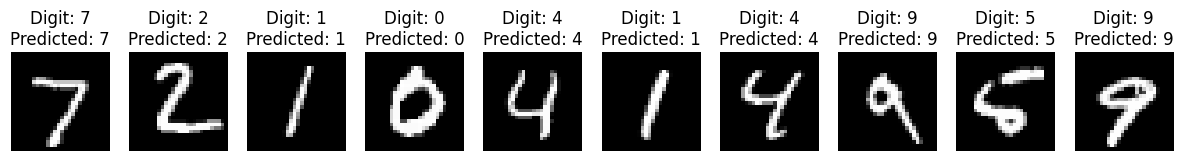

In [13]:
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

Si nota che la rete è in grado di riconoscere in maniera corretta tutte le cifre proposte.

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

### *Esercizio 12.3 - Soluzione proposta*
Per valutare la bontà della rete neurale convoluzionale sviluppata per l’Esercizio 12.2, si prova a far riconoscere al modello le 10 cifre scritte a mano.

In [14]:
from google.colab import files
import os

for i in range(10):
    filename = f"{i}.png"
    if os.path.exists(filename):
        os.remove(filename)

upload = files.upload()

Saving 0.png to 0.png
Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 7.png to 7.png
Saving 8.png to 8.png
Saving 9.png to 9.png


I use the previously trained DNN to predict the digit:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


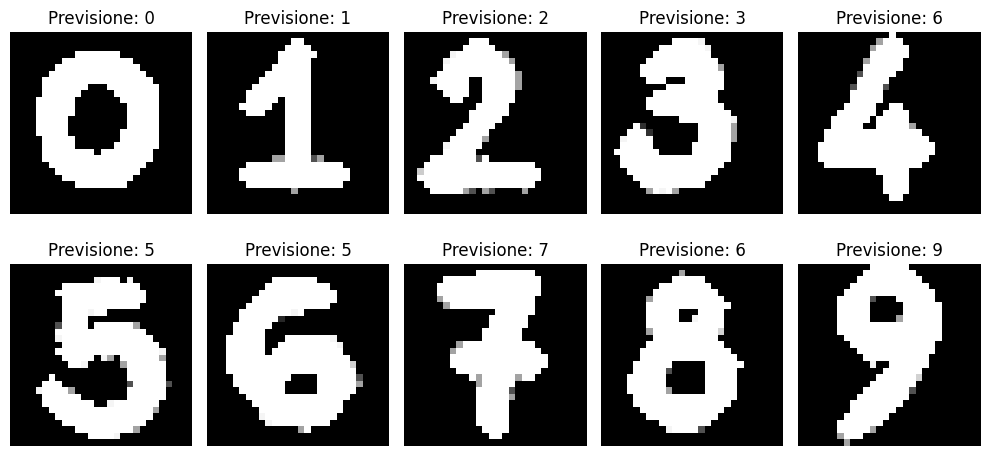

In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict_digit(filename):
    img = Image.open(filename).convert('L').resize((28, 28))
    data = np.array(img) / 255.0
    data = data.reshape(1, 28, 28).astype(np.float32)
    pred = model_CNN.predict(data)
    pred_digit = np.argmax(pred)
    return img, pred_digit  # Restituisce immagine e predizione

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    img, pred = predict_digit(f"{i}.png")
    r = i // 5
    c = i % 5
    axes[r, c].imshow(img, cmap='gray')
    axes[r, c].set_title(f"Previsione: {pred}")
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()


La rete non è in grado di riconoscere correttamente il 4, che viene classificato come 6, e il 6, che viene classificato come 5.
Questi errori suggeriscono che le cifre presentate in fase di test presentano dei pattern locali, come l’inclinazione, la curvatura o l’apertura dei tratti, che la rete non ha visto in fase di allenamento. Dunque, non riesce a generalizzare sempre in maniera efficace, fallendo nella classificazione di alcune cifre.
